### Create a distance matrix and compare to UMAP building its own distance matrix

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

### Collect data

In [4]:
DATASET_ID = 'BIRD_DB_Vireo_cassinii'

In [5]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'cassins.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/BIRD_DB_Vireo_cassinii/cassins.pickle')

In [6]:
syllable_df = pd.read_pickle(df_loc)

In [7]:
syllable_df["syll_len"] = syllable_df.end_time - syllable_df.start_time

In [8]:
len(syllable_df)

67032

In [9]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,spectrogram,syll_len
0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.19927763130383222, -0.2129138251615996, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3059005, 0.4...",0.263149
1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.12207342570633199, -0.09996911527363203, -...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.12574787, 0.12236...",0.315086
2,74.130176,74.376012,bz,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.0889848557398444, -0.06770700742932487, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2822944, 0.0...",0.245836


In [10]:
syllable_df['nsamp'] = [len(row.audio) for idx, row in tqdm(syllable_df.iterrows(), total=len(syllable_df))]

In [11]:
top_labels = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels.values == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:20]
    .T
)
top_labels

,en,au,ce,cj,ah,bm,ch,ai,db,aj,ck,hg,ac,ci,fq,ec,df,bx,cr,cl
0,2995,2077,1620,1506,1418,1379,1363,1362,1358,1305,1233,1180,1179,1080,1007,1003,986,984,978,971


In [12]:
subset_df= syllable_df[syllable_df.labels.isin(top_labels.columns)]
subset_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,spectrogram,syll_len,nsamp
0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.19927763130383222, -0.2129138251615996, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3059005, 0.4...",0.263149,11604
1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.12207342570633199, -0.09996911527363203, -...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.12574787, 0.12236...",0.315086,13896
12,114.757543,114.986067,bm,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.03662450122476042, -0.022604548403189744, ...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.228524,10078


In [13]:
subset_df = subset_df[:5000]

In [14]:
len(subset_df)

5000

### make distance matrix

In [15]:
from scipy.spatial.distance import squareform, pdist

In [16]:
specs = list(subset_df.spectrogram.values)
specs = [i/np.max(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(5000, 992)

In [17]:
pairs = [[a, specs_flattened[bi]]  for ai, a in tqdm(enumerate(specs_flattened), total=len(specs_flattened)) for bi in np.arange(ai+1, len(specs_flattened))]

In [18]:
#dists = [dtw_mse(i.T, j.T) for i, j in tqdm(pairs)]

In [19]:
from joblib import Parallel, delayed
from joblib import parallel_backend
from scipy.spatial import distance

In [20]:
distance.euclidean(specs_flattened[0], specs_flattened[1])

3.9593441486358643

In [21]:
with parallel_backend('multiprocessing', n_jobs=-1):
    with Parallel(verbose=0) as parallel:
        dists = parallel(
            delayed(np.correlate)(a, b) for a,b in tqdm(pairs))

In [30]:
dists_square = squareform(np.array(dists).flatten())

In [31]:
ensure_dir(DATA_DIR / 'scratch' )
np.save(DATA_DIR / 'scratch' / 'cassins_dists.npy', dists_square)

In [32]:
import umap

In [33]:
u = umap.UMAP(metric="precomputed")
z = u.fit_transform(X=dists_square)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap_learn-0.4.0rc1-py3.6.egg/umap/umap_.py:1477: UserWarning: Using precomputed metric; transform will be unavailable for new data
  warn("Using precomputed metric; transform will be unavailable for new data")
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap_learn-0.4.0rc1-py3.6.egg/umap/umap_.py:1709: UserWarning: Using precomputed metric; transform will be unavailable for new data
  "Using precomputed metric; transform will be unavailable for new data"


In [43]:
np.shape(dists_square)

(5000, 5000)

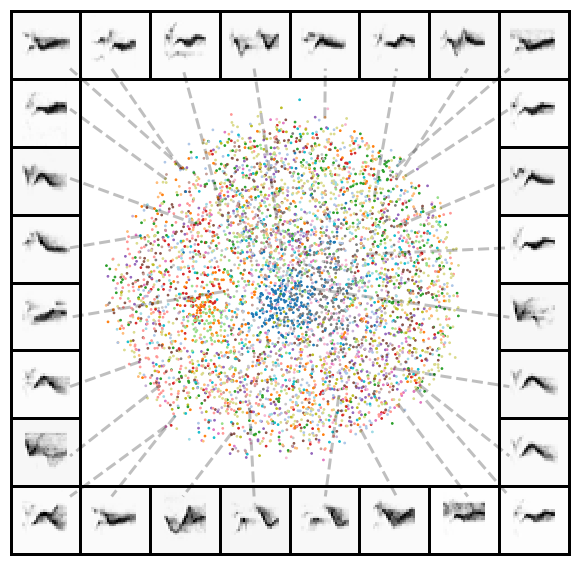

In [40]:
scatter_spec(
    z,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': subset_df.labels.values,
        'alpha':1,
        's': 3,
        'show_legend': False,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats')
#save_fig(FIGURE_DIR / 'cassins-specs-vs-feats' / 'UMAP_feats', dpi=300, save_jpg=True)

### UMAP on dtw

In [46]:
import umap
from avgn.metrics.dtw_mse import build_dtw_mse

In [44]:
np.shape(specs_flattened)

(5000, 992)

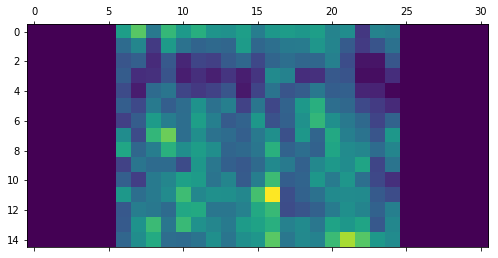

In [52]:
plt.matshow(specs[0][:15,:])

In [54]:
specs_T = np.array([i.T for i in specs])

In [56]:
dtw_metric = build_dtw_mse(specs_T[0].shape)

In [57]:
z_umap = umap.UMAP(metric=dtw_metric).fit_transform(specs_T.reshape(len(specs_T), -1))

In [61]:
subset_df['z_dtw_umap'] = list(z_umap)

In [62]:
subset_df.to_pickle(DATA_DIR / 'syllable_dfs' / DATASET_ID / 'cassins_small_dtw_umap.pickle')

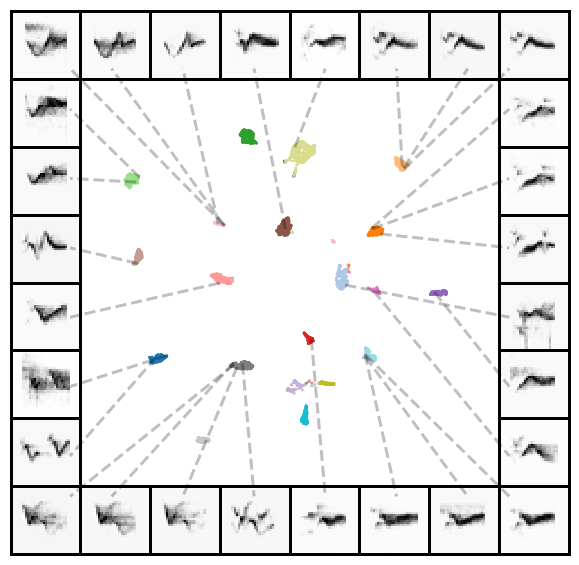

In [58]:
scatter_spec(
    z_umap,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': subset_df.labels.values,
        'alpha':1,
        's': 3,
        'show_legend': False,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats')
#save_fig(FIGURE_DIR / 'cassins-specs-vs-feats' / 'UMAP_feats', dpi=300, save_jpg=True)

### dtw with precomputed distance matrix

In [71]:
from avgn.metrics.dtw_mse import dtw_mse_single

In [67]:
pairs = [[a.T, specs[bi].T]  for ai, a in tqdm(enumerate(specs), total=len(specs)) for bi in np.arange(ai+1, len(specs))]

In [ ]:
with Parallel(n_jobs=-1, verbose=0, prefer="threads") as parallel:
    dists = parallel(
        delayed(dtw_mse_single)(i, j)
        for i, j in tqdm(pairs)
    )

In [ ]:
dists_square = squareform(np.array(dists).flatten())

In [ ]:
plt.matshow(dists_square)

In [ ]:
import umap

In [ ]:
u = umap.UMAP(metric="precomputed")

In [ ]:
z_precomputed = u.fit_transform(X=dists_square)

In [ ]:
scatter_spec(
    z_precomputed,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': subset_df.labels.values,
        'alpha':1,
        's': 3,
        'show_legend': False,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats')
#save_fig(FIGURE_DIR / 'cassins-specs-vs-feats' / 'UMAP_feats', dpi=300, save_jpg=True)